# Predicting Meteoroid Conditions

## Preliminar

### Modules

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.interpolate import interp1d as interpolate
from scipy.integrate import quad as integrate
import statistics as stats
import spiceypy as spy
from copy import deepcopy
from mpl_toolkits.basemap import Basemap as Map,shiftgrid as Grid
from tqdm import tqdm
%matplotlib nbagg

#Routines
def ipercs(xs,ps,qpercs):
    """
    Compute percentiles from a numerical normalized distribution ps
    """
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    fi=interpolate(Ps,xs)
    return fi(np.array(qpercs)/100.0)

#Routines to convert from local to body systems and viceversa
def loc2rec(vp,distance,Az,h):
    """
    Convert distance, azimuth and elevation to position w.r.t. Earth
    vp (dictionary): Vantage point.  It should have: lon, lat, alt
    distance: km
    Az: deg
    h: deg
    """
    rlocal=spy.latrec(distance,Az*DEG,h*DEG)
    rpos=spy.mxv(vp["l2b"],rlocal)+vp["geopos"]
    return rpos


def rec2loc(vp,rpos):
    """
    Convert position w.r.t. Earth to distance, Azimuth and elevation
    distance: km
    Az: deg
    h: deg
    """
    rrel=rpos-vp["geopos"]
    rlocal=spy.mxv(vp["b2l"],rrel)
    distance,Az,h=spy.reclat(rlocal)
    Az=2*np.pi+Az if Az<0 else Az
    return distance,Az*RAD,h*RAD

def updateVantagePoint(vp):
    """
    Compute related geometrical properties of a vantage point
    """
    vp["geopos"]=spy.georec(vp["lon"]*DEG,vp["lat"]*DEG,vp["alt"],RE,F)
    normal=spy.surfnm(RE,RE,RP,vp["geopos"])
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    vp["l2b"]=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    vp["b2l"]=np.linalg.inv(vp["l2b"])

### SPICE specifics

In [2]:
BDIR="./"
spy.furnsh(BDIR+"kernels/de430.bsp")
spy.furnsh(BDIR+"kernels/naif0012.tls")
spy.furnsh(BDIR+"kernels/pck00010.tpc")
spy.furnsh(BDIR+"kernels/earth_070425_370426_predict.bpc")
spy.furnsh(BDIR+"kernels/earth_assoc_itrf93.tf")
#Astronomical constants
n,rs=spy.bodvrd("EARTH","RADII",3)
RE=rs[0];RP=rs[2]
F=(RE-RP)/RE

### Macro and Constants

In [3]:
#Constants

#Cuba event
#"""
#IMPACT_DATA="grt-20190201181700-C033D9"
IMPACT_DATA="grt-Cuba-20190201181700-D60440"
IMPACT_SUFFIX="lat_2.27870e+01__lon_-8.37324e+01"
IMPACT_NAME="Cuba"
IMPACT_DATETIME="02/01/2019 18:17:00 UTC"
IMPACT_ET=spy.str2et(IMPACT_DATETIME)
IMPACT_CONDITIONS=dict(
    h=33,dh=0.7,
    Az=179,dAz=2,
    vimp=18.00,dvimp=0.5,
    a = 1.32, da = 0.062,
    q = 0.75, dq = 0.018,
    e = 0.44, de = 0.023,
    i = 11.68, di = 0.39,
    W = 132.54, dW = 0.0033,
    o = 283.77, do = 4.1,
    P = 1.52, dP = 0.11,
    Tp = 2.78, dTp = 0.02,
)
#"""

#Chelyabinsk
"""
#IMPACT_DATA="grt-general-20130215032034-6F5A97"
IMPACT_DATA="grt-Chelyabinsk-20130215032034-979193"
IMPACT_SUFFIX="lat_5.44000e+01__lon_6.35000e+01"
IMPACT_NAME="Chelyabinsk"
IMPACT_DATETIME="02/15/2013 3:20:34 UTC"
IMPACT_ET=spy.str2et(IMPACT_DATETIME)
IMPACT_CONDITIONS=dict(
    #Local
    h=18.55,dh=0,
    Az=103.5,dAz=0,
    vimp=19.03,dvimp=0,
    #Orbitla Elements
    q=0.738,dq=0,
    a=1.72,da=0,
    e=0.571,de=0,
    i=4.98,di=0,
    W=326.459,dW=0,
    o=107.67,do=0,
)
#"""

#Directories
FIGDIR=BDIR+"figures/"

#Macros
norm=np.linalg.norm
DEG=np.pi/180
RAD=1/DEG

## GRT Analysis

### Read data

In [4]:
data_rays=np.loadtxt(BDIR+f"data/{IMPACT_DATA}/rays-{IMPACT_SUFFIX}.data.phys")
data_rays_prob=np.loadtxt(BDIR+f"data/{IMPACT_DATA}/rays-{IMPACT_SUFFIX}.data.prob")
orden=data_rays_prob[:,7].argsort()[::-1]
aes=data_rays[:,9]/(1-data_rays[:,10])
Nrays=len(data_rays)
data_rays=np.append(data_rays,aes.reshape(Nrays,1),axis=1)
print(f"Number of test trajectories read: {Nrays}")

Number of test trajectories read: 38432


### Marginal distributions

#### Compute marginal histograms

In [5]:
properties=dict(
    h=dict(indice=0,property="h",factor=30,units='deg',latex=r"h",range=(None,None),error=True),
    vimp=dict(indice=2,property="vimp",factor=3,units='deg',latex=r"v_{\rm imp}",range=(None,None),error=True),
    Az=dict(indice=1,property="Az",factor=30,units='deg',latex=r"A",range=(0.0,360.0),error=False),
    a=dict(indice=16,property="a",factor=1000,units='AU',latex=r"a",range=(0.5,2.5),error=True),
    q=dict(indice=9,property="q",factor=1000,units='AU',latex=r"q",range=(0.5,1.1),error=True),
    e=dict(indice=10,property="e",factor=1000,units='deg',latex=r"e",range=(0.0,1.0),error=True),
    i=dict(indice=11,property="i",factor=1000,units='deg',latex=r"i",range=(0.0,20.0),error=False),
    W=dict(indice=12,property="W",factor=1000,units='deg',latex=r"\Omega",range=(0.0,360.0),error=False),
    o=dict(indice=13,property="o",factor=1000,units='deg',latex=r"\omega",range=(0.0,360.0),error=False)
)

In [6]:
pprob=data_rays_prob[:,7]
print("Computed rays:",len(pprob))
for key,qprop in properties.items():
    #qprop=properties[-2]
    print(f"Computing ppd for {qprop['property']}")
    rang=qprop["range"]
    if rang[0] is None:qrange=0
    else:qrange=1
          
    xs=data_rays[:,qprop["indice"]]
    if qrange:cond=(xs>=rang[0])*(xs<=rang[1])
    else:cond=(xs>-1e100)
    xs=xs[cond]
        
    xun=np.unique(xs)
    Nun=len(xun)
    print("\tUnique values of property:",Nun)

    # Range of elevations                                                                                                                                                                                                                                     
    xmin=xs.min()
    xmax=xs.max()
    print("\tRanges:",xmin,xmax)

    # Create boxes                                                                                                                                                                                                                                            
    Nb=int(Nun/qprop["factor"])
    print("\tSampling points:",Nb)
    xb=np.linspace(xmin,1.01*xmax,Nb,endpoint=False)
    dxb=xb[1]-xb[0]

    # Compute probabilities                                                                                                                                                                                                                                   
    P=0
    hb=np.zeros(Nb)
    for i,x in enumerate(xs):
        p=pprob[i]
        P+=p
        n=int((x-xmin)/dxb)
        hb[n]+=p

    hb=np.array(hb)
    hb/=P

    #Save histogram
    fname=BDIR+f"data/{qprop['property']}-marginal-{IMPACT_NAME}.dat"
    print(f"\tSaving {fname}")
    np.savetxt(fname,np.vstack((xb,hb)).transpose())
    #break

Computed rays: 38432
Computing ppd for h
	Unique values of property: 498
	Ranges: 0.27798 83.332
	Sampling points: 16
	Saving ./data/h-marginal-Cuba.dat
Computing ppd for vimp
	Unique values of property: 100
	Ranges: 11.471 43.039
	Sampling points: 33
	Saving ./data/vimp-marginal-Cuba.dat
Computing ppd for Az
	Unique values of property: 498
	Ranges: 0.27282 359.06
	Sampling points: 16
	Saving ./data/Az-marginal-Cuba.dat
Computing ppd for a
	Unique values of property: 31106
	Ranges: 0.5317475410929965 2.4999006627315783
	Sampling points: 31
	Saving ./data/a-marginal-Cuba.dat
Computing ppd for q
	Unique values of property: 29167
	Ranges: 0.5000118981138796 1.0029277955300635
	Sampling points: 29
	Saving ./data/q-marginal-Cuba.dat
Computing ppd for e
	Unique values of property: 38432
	Ranges: 0.003874320342935637 0.9939379318396011
	Sampling points: 38
	Saving ./data/e-marginal-Cuba.dat
Computing ppd for i
	Unique values of property: 29276
	Ranges: 0.00022667234309423513 19.99949762099985

#### Plot marginal histograms

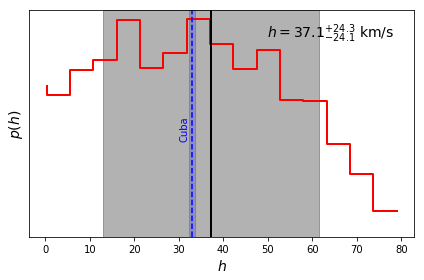

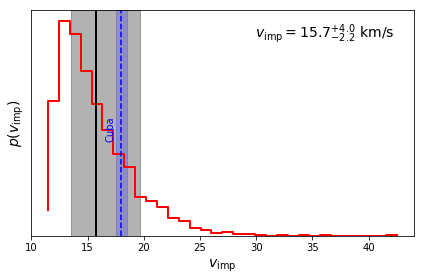

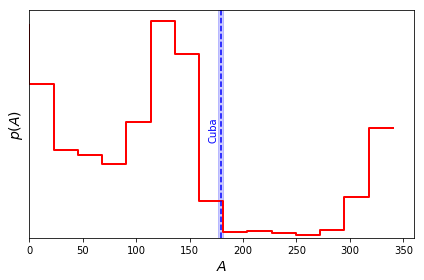

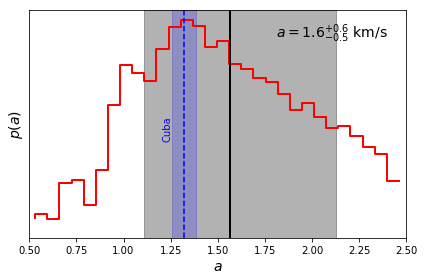

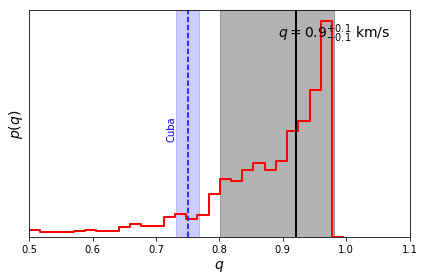

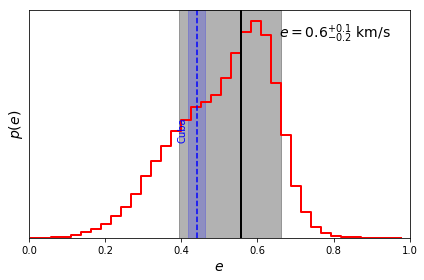

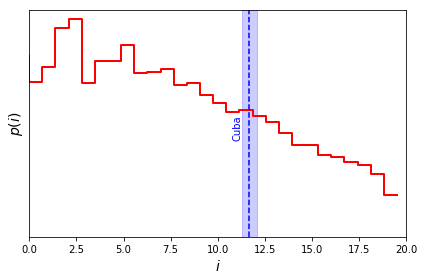

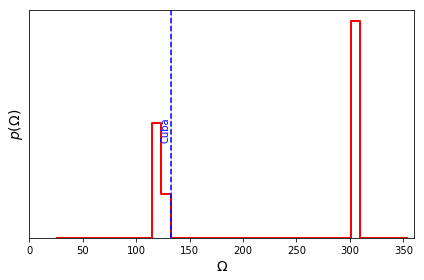

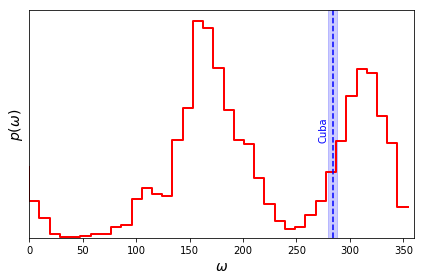

In [7]:
for key,qprop in properties.items():
    #qprop=properties[-1]
    prop=qprop['property']
    latex=qprop['latex']
    
    #Marginal distribution
    data=np.loadtxt(BDIR+f"data/{prop}-marginal-{IMPACT_NAME}.dat")
    vs=data[:,0]
    ps=data[:,1]

    v1,vm,v2=ipercs(vs,ps,[15.0,50.0,85.0])
    mv=vm-v1;pv=v2-vm

    #Plot
    fig=plt.figure()
    ax=fig.gca()
    ax.step(vs,ps,color='r',lw=2)
    
    ax.set_xlabel(r"$%s$"%latex,fontsize=14)
    ax.set_ylabel(r"$p(%s)$"%latex,fontsize=14)

    ax.set_yticks([])
    
    if qprop["error"]:
        ax.axvspan(v1,vm,color='k',alpha=0.3)
        ax.axvline(vm,color='k',lw=2)
        ax.axvspan(vm,v2,color='k',alpha=0.3)
        ax.text(0.95,0.95,r"$%s=%.1lf^{+%.1lf}_{-%.1lf}$ km/s"%(latex,vm,pv,mv),
                transform=ax.transAxes,ha='right',va='top',fontsize=14)

    ax.axvline(IMPACT_CONDITIONS[prop],ls='--',color='b')
    ax.axvspan(IMPACT_CONDITIONS[prop]-IMPACT_CONDITIONS["d"+prop],
               IMPACT_CONDITIONS[prop]+IMPACT_CONDITIONS["d"+prop],color='b',alpha=0.2)
    ax.text(IMPACT_CONDITIONS[prop]-IMPACT_CONDITIONS["d"+prop],ps.max()/2,IMPACT_NAME,rotation=90,ha='right',va='center',color='b')

    ymin,ymax=ax.get_ylim()
    ax.set_ylim((0,ymax))
    
    if not qprop['range'][0] is None:
        ax.set_xlim(qprop['range'])
        

    fig.tight_layout()
    fig.savefig(FIGDIR+f"{prop}-ppd-{IMPACT_NAME}.png")
    #break

### 2-D Histograms

#### Properties and combinations

In [8]:
#Properties
props=dict(
    h=dict(n=0,min=0.0,max=90.0,N=10),
    Az=dict(n=1,min=0.0,max=360.0,N=10),
    a=dict(n=16,min=0.5,max=2.0,N=10),
    q=dict(n=9,min=0.5,max=1.1,N=10),
    e=dict(n=10,min=0.0,max=1.0,N=10),
    i=dict(n=11,min=0.0,max=+20.0,N=10),
    W=dict(n=12,min=0.0,max=360.0,N=10),
    o=dict(n=13,min=0.0,max=360.0,N=10),
)

#Delta in properties
for key,prop in props.items():
    prop["del"]=(prop["max"]-prop["min"])/prop["N"]

#Propeties combination
combs=dict(
    Azh=dict(
        p1="Az",
        p2="h"
    ),
    ae=dict(
        p1="a",
        p2="e"
    ),
    qe=dict(
        p1="q",
        p2="e"
    ),
    ie=dict(
        p1="i",
        p2="e"
    ),
    Wo=dict(
        p1="W",
        p2="o"
    ),
)

#Histograms initialization
for key,comb in combs.items():
    comb["his"]=np.zeros((props[comb["p2"]]["N"],props[comb["p1"]]["N"]))

#### Compute histograms

In [9]:
for key,comb in combs.items():

    #Properties
    prop1=props[comb["p1"]]
    prop2=props[comb["p2"]]

    #Initialize
    j=0
    P=0
    for i in tqdm(range(len(data_rays)),desc=key):

        #Propety values 
        p1=data_rays[i,prop1["n"]]
        p2=data_rays[i,prop2["n"]]
        p=data_rays_prob[i,7]

        #Position in the histogram
        np1=int((p1-prop1["min"])/prop1["del"])
        np2=int((p2-prop2["min"])/prop2["del"])

        #Skip values beyond limits
        if np1>=prop1["N"] or np2>=prop2["N"]:continue
        comb["his"][np2,np1]+=p
        P+=p
        j+=1
    comb["his"]/=P

Wo: 100%|██████████| 38432/38432 [00:00<00:00, 39256.78it/s]


#### Plot histograms

Saving ./figures/Azh-Cuba.png
Saving ./figures/ae-Cuba.png
Saving ./figures/qe-Cuba.png
Saving ./figures/ie-Cuba.png
Saving ./figures/Wo-Cuba.png


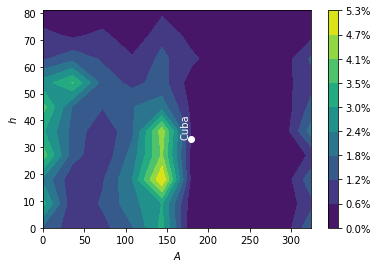

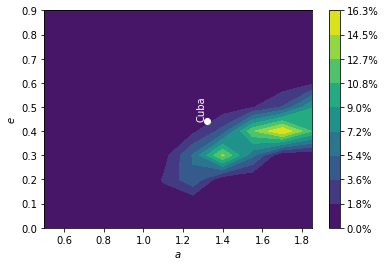

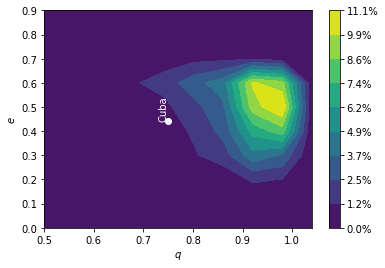

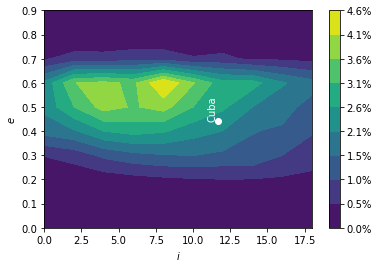

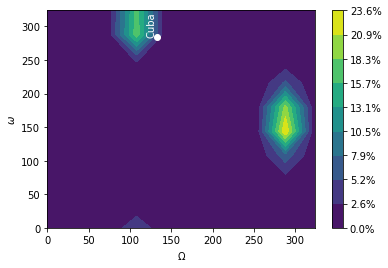

In [10]:
#Map
#key="Ww"
#comb=combs[key]
for key,comb in combs.items():
    name1=properties[comb["p1"]]["latex"]
    name2=properties[comb["p2"]]["latex"]
    
    prop1=props[comb["p1"]]
    prop2=props[comb["p2"]]
    P1s,P2s=np.meshgrid(np.arange(prop1["min"],prop1["max"],prop1["del"]),
                        np.arange(prop2["min"],prop2["max"],prop2["del"]))
    hmin=comb["his"].min();hmax=comb["his"].max()
    
    fig=plt.figure()
    ax=fig.gca()

    c=ax.contourf(P1s,P2s,comb["his"],levels=np.linspace(hmin,hmax,10))
    cbar=fig.colorbar(c)
    #cbar.ax.set_ylabel('Fraction of Trajetcories',fontsize=12)

    ax.plot([IMPACT_CONDITIONS[comb["p1"]]],[IMPACT_CONDITIONS[comb["p2"]]],'wo')
    ax.text(IMPACT_CONDITIONS[comb["p1"]],IMPACT_CONDITIONS[comb["p2"]],
            IMPACT_NAME,zorder=100,color='w',ha='right',va='bottom',rotation=90)

    ytl=[]
    for y in cbar.ax.get_yticks():
        ytl+=["%.1f%%"%((hmin+y*(hmax-hmin))*100)]
    cbar.ax.set_yticklabels(ytl)

    ax.set_xlabel(f"${name1}$")
    ax.set_ylabel(f"${name2}$")
    
    ax.set_xlim((prop1["min"],prop1["max"]-prop1["del"]))
    ax.set_ylim((prop2["min"],prop2["max"]-prop2["del"]))

    fname=FIGDIR+f"{key}-{IMPACT_NAME}.png"
    print(f"Saving {fname}")
    fig.savefig(fname)

### Tisserand parameters

In [11]:
#Cuba event
#"""
Impacts=dict(
    Cuba=dict(
        IMPACT_DATA="grt-Cuba-20190201181700-D60440",
        IMPACT_SUFFIX="lat_2.27870e+01__lon_-8.37324e+01",
        IMPACT_NAME="Cuba",
        IMPACT_DATETIME="02/01/2019 18:17:00 UTC",
        IMPACT_ET=spy.str2et(IMPACT_DATETIME),
        IMPACT_CONDITIONS=dict(
            h=33.3,Az=179.0,vimp=18.11,
            q=0.713925,a=1.31326017,e=0.456372,i=11.574326,W=132.532128,o=278.527160,
        ),
    ),
    Chelyabinsk=dict(
        #IMPACT_DATA="grt-general-20130215032034-6F5A97",
        IMPACT_DATA="grt-Chelyabinsk-20130215032034-979193",
        IMPACT_SUFFIX="lat_5.44000e+01__lon_6.35000e+01",
        IMPACT_NAME="Chelyabinsk",
        IMPACT_DATETIME="02/15/2013 3:20:34 UTC",
        IMPACT_ET=spy.str2et(IMPACT_DATETIME),
        IMPACT_CONDITIONS=dict(
            #Local
            h=20.0,Az=100.0,vimp=19.3,
            #Orbitla Elements
            q=0.74,a=1.76,e=0.58,i=4.93,W=326.442,o=108.3
        ),
    ),
)


In [12]:
#Tisserand parameter
site="Cuba"
q=Impacts[site]["IMPACT_CONDITIONS"]["q"]
e=Impacts[site]["IMPACT_CONDITIONS"]["e"]
i=Impacts[site]["IMPACT_CONDITIONS"]["i"]
a=q/(1-e)
Tp=1/a+2*np.cos(i*DEG)*np.sqrt(a*(1-e**2))
Tp

2.7593472197609628

In [13]:
#Tisserand parameter
site="Chelyabinsk"
q=Impacts[site]["IMPACT_CONDITIONS"]["q"]
e=Impacts[site]["IMPACT_CONDITIONS"]["e"]
i=Impacts[site]["IMPACT_CONDITIONS"]["i"]
a=q/(1-e)
Tp=1/a+2*np.cos(i*DEG)*np.sqrt(a*(1-e**2))
Tp

2.722157960905861